# This notebook will explore gene set enrichment of in stages and clusters

## Imports

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import harmony
import random
np.random.seed(0)
random.seed(0)

## Settings

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
sc.settings.verbosity = 0 


## Loading individual datasets

In [17]:
def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [18]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [19]:
#loading and concatenating files
stages = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , stages)



In [20]:
counts = concat_for_harmony(adatas, stages)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [21]:
#Cell type colors from integrated annotation
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [22]:
colors['color'].to_csv('../intermediate_files/phenograph_colors.tsv', sep = '\t')

In [23]:
%matplotlib inline

In [24]:
tp = pd.Series(index=data_df.index)
for t in stages:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

## Plotting marker genes

In [25]:
from IndividualAnalysis import plot_ind_cell_clusters, plot_gene_expression

## Cluster individual datasets

### Clustering for UMAPs

In [11]:
##Underclustering
resolution = [0.2, 0.2, 0.3, 
              0.3, 0.3,0.3, 0.3, 
              0.01, 0.1,0.18 ] 


#Perform standard scanpy processing of datasets to get graph based clustering
clusters = []
for i in range(len(adatas)):
    sc.pp.filter_genes(adatas[i], min_cells=3)
    adatas[i].obs.index = ['_'.join([adatas[i].obs.stage[0], x]) for x in adatas[i].obs.index]
    #sc.pp.filter_genes(adatas[i], min_cells=1, inplace = True)
    sc.pp.normalize_per_cell(adatas[i], counts_per_cell_after=1e4)
    sc.pp.log1p(adatas[i])

    sc.pp.highly_variable_genes(adatas[i], min_mean=0.0125, max_mean=3, min_disp=0.5)

    adatas[i] = adatas[i][:, adatas[i].var.highly_variable]

    sc.pp.scale(adatas[i], max_value=10)
    sc.tl.pca(adatas[i], svd_solver='arpack')

    sc.pp.neighbors(adatas[i], n_neighbors=10, n_pcs=40)
    sc.tl.umap(adatas[i])
    sc.tl.louvain(adatas[i], resolution = resolution[i])
    print('{} has {} cluster as current resolution'.format(adatas[i].obs.stage[0], len(set(adatas[i].obs.louvain))))
    #adatas[i].obs['New_clust'] = adatas[i].obs.louvain.map(mapper[adatas[i].obs.stage[0]])
    clusters.append(adatas[i].obs.louvain)

clusters_local = pd.concat(clusters)
clusters_local = clusters_local.map(int)

st08 has 1 cluster as current resolution
st10.5 has 1 cluster as current resolution
st12 has 2 cluster as current resolution
st13 has 3 cluster as current resolution
st16 has 3 cluster as current resolution
st18 has 4 cluster as current resolution
st20 has 4 cluster as current resolution
st22 has 5 cluster as current resolution
st24 has 5 cluster as current resolution
st27 has 5 cluster as current resolution


In [13]:
clusters_local = clusters_local.astype(str) + '_' + tp

In [164]:
import pickle
with open('../intermediate_files/louvain_for_umap', "wb") as f:
    pickle.dump(clusters_local, f)

### Clustering for lineage

In [20]:
##overclustering
resolution = [0.2, 0.2, 0.3, 
              0.3, 0.5,0.3, 0.3, 
              0.6, 1,1 ] 


#Perform standard scanpy processing of datasets to get graph based clustering
clusters = []
for i in range(len(adatas)):
    sc.pp.filter_genes(adatas[i], min_cells=3)
    adatas[i].obs.index = ['_'.join([adatas[i].obs.stage[0], x]) for x in adatas[i].obs.index]
    #sc.pp.filter_genes(adatas[i], min_cells=1, inplace = True)
    sc.pp.normalize_per_cell(adatas[i], counts_per_cell_after=1e4)
    sc.pp.log1p(adatas[i])

    sc.pp.highly_variable_genes(adatas[i], min_mean=0.0125, max_mean=3, min_disp=0.5)

    adatas[i] = adatas[i][:, adatas[i].var.highly_variable]

    sc.pp.scale(adatas[i], max_value=10)
    sc.tl.pca(adatas[i], svd_solver='arpack')

    sc.pp.neighbors(adatas[i], n_neighbors=10, n_pcs=40)
    sc.tl.umap(adatas[i])
    sc.tl.louvain(adatas[i], resolution = resolution[i])
    print('{} has {} cluster as current resolution'.format(adatas[i].obs.stage[0], len(set(adatas[i].obs.louvain))))
    #adatas[i].obs['New_clust'] = adatas[i].obs.louvain.map(mapper[adatas[i].obs.stage[0]])
    clusters.append(adatas[i].obs.louvain)

clusters_local = pd.concat(clusters)
clusters_local = clusters_local.map(int)

st08 has 1 cluster as current resolution
st10.5 has 1 cluster as current resolution
st12 has 2 cluster as current resolution
st13 has 3 cluster as current resolution
st16 has 4 cluster as current resolution
st18 has 4 cluster as current resolution
st20 has 4 cluster as current resolution
st22 has 8 cluster as current resolution
st24 has 8 cluster as current resolution
st27 has 9 cluster as current resolution


In [21]:
clusters_local = clusters_local.astype(str) + '_' + tp

In [22]:
import pickle
with open('../intermediate_files/louvain_for_lineage_V3', "wb") as f:
    pickle.dump(clusters_local, f)

In [ ]:
#Leiden

In [26]:
##overclustering
resolution = [0.2, 0.2, 0.3, 
              0.3, 0.5,0.3, 0.3, 
              0.6, 1,1 ] 


#Perform standard scanpy processing of datasets to get graph based clustering
clusters = []
for i in range(len(adatas)):
    sc.pp.filter_genes(adatas[i], min_cells=3)
    adatas[i].obs.index = ['_'.join([adatas[i].obs.stage[0], x]) for x in adatas[i].obs.index]
    #sc.pp.filter_genes(adatas[i], min_cells=1, inplace = True)
    sc.pp.normalize_per_cell(adatas[i], counts_per_cell_after=1e4)
    sc.pp.log1p(adatas[i])

    sc.pp.highly_variable_genes(adatas[i], min_mean=0.0125, max_mean=3, min_disp=0.5)

    adatas[i] = adatas[i][:, adatas[i].var.highly_variable]

    sc.pp.scale(adatas[i], max_value=10)
    sc.tl.pca(adatas[i], svd_solver='arpack')

    sc.pp.neighbors(adatas[i], n_neighbors=10, n_pcs=40)
    sc.tl.umap(adatas[i])
    sc.tl.leiden(adatas[i], resolution = resolution[i])
    print('{} has {} cluster as current resolution'.format(adatas[i].obs.stage[0], len(set(adatas[i].obs.leiden))))
    #adatas[i].obs['New_clust'] = adatas[i].obs.louvain.map(mapper[adatas[i].obs.stage[0]])
    clusters.append(adatas[i].obs.leiden)

clusters_local = pd.concat(clusters)
clusters_local = clusters_local.map(int)

st08 has 1 cluster as current resolution
st10.5 has 1 cluster as current resolution
st12 has 2 cluster as current resolution
st13 has 3 cluster as current resolution
st16 has 4 cluster as current resolution
st18 has 4 cluster as current resolution
st20 has 4 cluster as current resolution
st22 has 8 cluster as current resolution
st24 has 9 cluster as current resolution
st27 has 9 cluster as current resolution


In [27]:
clusters_local = clusters_local.astype(str) + '_' + tp

In [28]:
import pickle
with open('../intermediate_files/leiden_for_lineage_V3', "wb") as f:
    pickle.dump(clusters_local, f)

# Plot clusterings on UMAPs

## Phenograph clustering (on integrated data)

In [166]:
import pickle
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


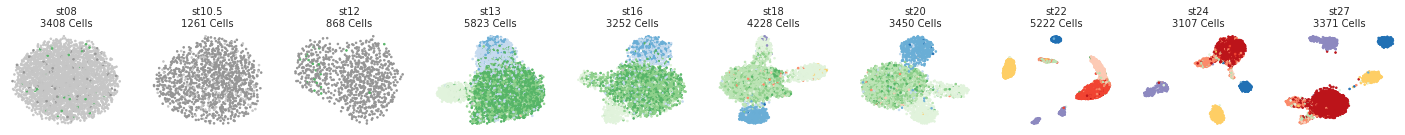

In [167]:

n_rows = 1
n_cols = 10
fig = plt.figure(figsize=[ n_cols*3, 1*3])
gs = plt.GridSpec(n_rows + 2, n_cols+2,
                  height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows)))
for i in range(len(adatas)):
    ax = plt.subplot(gs[0:2, i])
        
    umap = pd.DataFrame(adatas[i].obsm['X_umap'])
    umap.columns = ['X', 'Y']
    umap.index = adatas[i].obs_names
        
    clust = clusters[umap.index]    
    #clust = adatas[i].obs.louvain

    ax.scatter(x =umap.X, y = umap.Y, s=3,
               c=colors.color[clust[umap.index].map(int)]) 
        
    ax.set_axis_off()
    ax.set_title(adatas[i].obs.stage[1] + '\n{} Cells'.format(len(adatas[i].obs_names)), fontsize=10)
    ax.set_rasterized(True)
#plt.savefig('figures/ind_umap_palantir_clusters.pdf')
        

## For UMAPs (Low resolution loouvain on individual stages) 

In [168]:
new_col = {'st08':[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778)],
         'st10.5':[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778)],
         'st12':[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778), 
                 (0.586082276047674, 0.586082276047674, 0.586082276047674)],
         'st13':[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),
                (0.7752402921953095, 0.8583006535947711, 0.9368242983467897),
                (0.3388235294117647, 0.7117262591311034, 0.40584390618992694)],
         'st16':[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),
                (0.7752402921953095, 0.8583006535947711, 0.9368242983467897),
                (0.3388235294117647, 0.7117262591311034, 0.40584390618992694)],
         'st18':[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),
                (0.7752402921953095, 0.8583006535947711, 0.9368242983467897),
                (0.3388235294117647, 0.7117262591311034, 0.40584390618992694),
                (0.8828143021914648, 0.9546943483275664, 0.8621914648212226)],
         'st20':[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),
                (0.7752402921953095, 0.8583006535947711, 0.9368242983467897),
                (0.3388235294117647, 0.7117262591311034, 0.40584390618992694),
                (0.8828143021914648, 0.9546943483275664, 0.8621914648212226)],
         'st22':[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
                (0.996078431372549, 0.8091503267973856, 0.39607843137254906),
                (0.41708573625528644, 0.6806305267204922, 0.8382314494425221),
                (0.5513264129181085, 0.537916186082276, 0.7524490580545944),
                (0.7371472510572856, 0.895517108804306, 0.7108342945021145)],
         'st24':[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
                (0.996078431372549, 0.8091503267973856, 0.39607843137254906),
                (0.5513264129181085, 0.537916186082276, 0.7524490580545944),
                (0.41708573625528644, 0.6806305267204922, 0.8382314494425221),
                (0.7364705882352941, 0.08, 0.10117647058823528)],
         'st27':[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
                (0.5513264129181085, 0.537916186082276, 0.7524490580545944),
                (0.996078431372549, 0.8091503267973856, 0.39607843137254906),
                (0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
                (0.7364705882352941, 0.08, 0.10117647058823528)]}

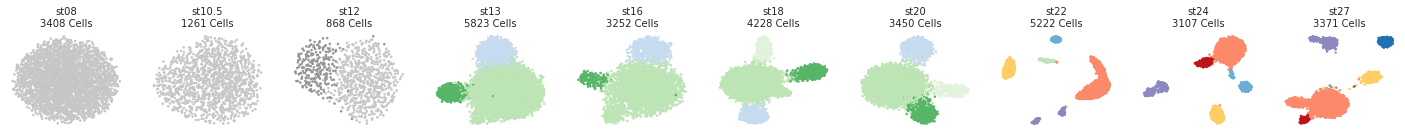

In [205]:

n_rows = 1
n_cols = 10
fig = plt.figure(figsize=[ n_cols*3, 1*3])
gs = plt.GridSpec(n_rows + 2, n_cols+2,
                  height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows)))
complete_cols = []
for i in range(len(adatas)):
    ax = plt.subplot(gs[0:2, i])
        
    umap = pd.DataFrame(adatas[i].obsm['X_umap'])
    umap.columns = ['X', 'Y']
    umap.index = adatas[i].obs_names
        
    #clust = clusters[umap.index]    
    clust = adatas[i].obs.louvain
    col = pd.Series(sns.color_palette("hls", 5))
    col = pd.Series(new_col[adatas[i].obs.stage[1]])
    col2 = col.copy()
    col2.index = [str(x) + '_' + adatas[i].obs.stage[1] for x in col2.index]
    complete_cols.append(col2)
    ax.scatter(x =umap.X, y = umap.Y, s=3,
               c=col[clust[umap.index].map(int)]) 
        
    ax.set_axis_off()
    ax.set_title(adatas[i].obs.stage[1] + '\n{} Cells'.format(len(adatas[i].obs_names)), fontsize=10)
    ax.set_rasterized(True)
#plt.savefig('figures/ind_umap_low_res_louvain.pdf')
        

In [207]:
cmap = pd.concat(complete_cols)

In [168]:
for i in range(len(adatas)):
    umap = pd.DataFrame(adatas[i].obsm['X_umap'])
    umap.columns = ['X', 'Y']
    umap.index = adatas[i].obs_names
    umap.to_csv('Ind_coord/umap_coord_{}.txt'.format(adatas[i].obs.stage[0]), header = False, index = None)

In [135]:
loc_clust = pd.read_csv('../Sup_tables/Intermediate/local_clusters_low_res.tsv', sep = '\t')